In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split

In [2]:
!wget https://storage.googleapis.com/sweple.appspot.com/dataset229.zip

--2024-06-16 14:40:09--  https://storage.googleapis.com/sweple.appspot.com/dataset229.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.251.18.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387892589 (370M) [application/zip]
Saving to: ‘dataset229.zip’

dataset229.zip      100%[===================>] 369.92M  9.84MB/s    in 40s     

2024-06-16 14:40:51 (9.29 MB/s) - ‘dataset229.zip’ saved [387892589/387892589]



In [5]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset229.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
# Split dataset into training and testing sets

dataset_dir = "dataset"
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for i in os.listdir(dataset_dir):
    sub_dir = os.listdir(os.path.join(dataset_dir, i))
    for j in sub_dir:
        cat_dir = os.path.join(os.path.join(dataset_dir, i), j)

        if os.path.isdir(cat_dir):
            os.makedirs(os.path.join(train_dir, j), exist_ok=True)
            os.makedirs(os.path.join(test_dir, j), exist_ok=True)

            images = os.listdir(cat_dir)

            train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

            for image in train_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(train_dir, j, image))
            for image in test_images:
                shutil.move(os.path.join(cat_dir, image), os.path.join(test_dir, j, image))

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 52348 images belonging to 283 classes.
Found 4245 images belonging to 283 classes.


In [8]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 52348
Testing samples: 4245


In [ ]:
print("Class Indicate", train_generator.class_indices)

In [9]:
# Create a MirroredStrategy to use both GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

# Compile the model under the MirroredStrategy
with mirrored_strategy.scope():
    # Load pre-trained InceptionV3 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(len(classes_train), activation='softmax')(x)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=Adam(),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_generator,
                        epochs=10,
                        validation_data=test_generator,
                        verbose=1)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
1636/1636 [==============================] - 784s 471ms/step - loss: 1.5524 - accuracy: 0.7118 - val_loss: 0.2933 - val_accuracy: 0.9143
Epoch 2/10
1636/1636 [==============================] - 766s 468ms/step - loss: 0.3117 - accuracy: 0.9110 - val_loss: 0.1402 - val_accuracy: 0.9545
Epoch 3/10
1636/1636 [==============================] - 757s 463ms/step - loss: 0.2336 - accuracy: 0.9265 - val_loss: 0.1422 - val_accuracy: 0.9491
Epoch 4/10
1636/1636 [==============================] - 758s 463ms/step - loss: 0.1952 - accuracy: 0.9362 - val_loss: 0.0969 - val_accuracy: 0.9628
Epoch 5/10
1636/1636 [==============================] - 760s 465ms/step - loss: 0.1829 - accuracy: 0.9394 - val_loss: 0.0649 - val_accuracy: 0.9764
Epoch 6/10
1636/1636 [==============================] - 752s 460ms/step - loss: 0.1708 - accuracy: 0.9417 - val_loss: 0.0854 - val_accuracy: 0.9722
Epoch 7/10
1636/1636 [=========================

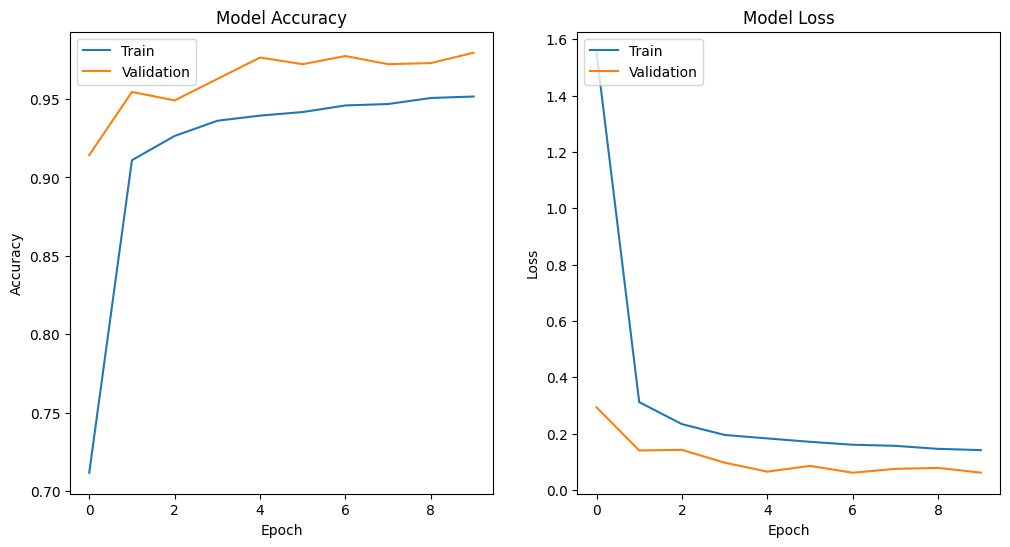

In [10]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Saving Cimory Fresh Milk Uht Cashew 250Ml to Cimory Fresh Milk Uht Cashew 250Ml
User uploaded file "Cimory Fresh Milk Uht Cashew 250Ml" with length 58441 bytes
1/1 [==============================] - 0s 66ms/step


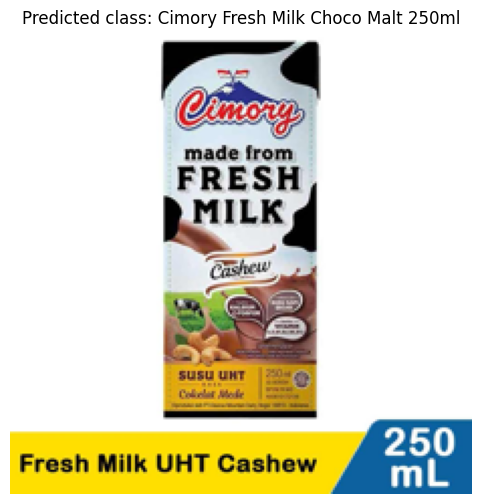

In [17]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [18]:
#save your model in the SavedModel format
export_dir = 'vgg16/saved_model'
tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('vgg16_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [19]:
#Save the keras model after compiling
model.save('vgg16_model.h5')
model_keras = tf.keras.models.load_model('vgg16_model.h5')
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_keras)
tflite_model = converter.convert()

# Save the model.
with open('vgg16_model_keras.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
!zip -r vgg16.zip vgg16/

  adding: vgg16/ (stored 0%)
  adding: vgg16/saved_model/ (stored 0%)
  adding: vgg16/saved_model/fingerprint.pb (stored 0%)
  adding: vgg16/saved_model/variables/ (stored 0%)
  adding: vgg16/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: vgg16/saved_model/variables/variables.index (deflated 69%)
  adding: vgg16/saved_model/assets/ (stored 0%)
  adding: vgg16/saved_model/saved_model.pb (deflated 89%)


In [25]:
!mv vgg16_model_keras.tflite /content/drive/MyDrive